In [ ]:
pip install pandas geopandas shapely


In [ ]:
pip install transformers torch pandas geopandas shapely folium


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
from transformers import BertTokenizer, BertForTokenClassification
import torch

# Load pre-trained model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=9)  # Adjust num_labels as needed

# Function to recognize entities
def extract_geospatial_entities(text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs).logits
    predictions = torch.argmax(outputs, dim=2)
    tokens = tokenizer.tokenize(tokenizer.decode(inputs.input_ids[0]))
    entities = [tokens[i] for i, pred in enumerate(predictions[0]) if pred != 0]
    return entities

user_query = "Show me all parks in San Francisco"
entities = extract_geospatial_entities(user_query)
print("Recognized geospatial entities:", entities)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Recognized geospatial entities: ['[CLS]', 'Show', 'me', 'all', 'parks', 'in', 'Francisco', '[SEP]']


In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load GeoNames dataset
file_path = '/content/allCountries.txt'
columns = ['geonameid', 'name', 'asciiname', 'alternatenames', 'latitude', 'longitude', 'feature_class', 'feature_code', 'country_code', 'cc2', 'admin1_code', 'admin2_code', 'admin3_code', 'admin4_code', 'population', 'elevation', 'dem', 'timezone', 'modification_date']
df = pd.read_csv(file_path, sep='\t', names=columns) # Load data from the file into a DataFrame called 'df'
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf = gdf[['name', 'latitude', 'longitude', 'feature_class', 'feature_code', 'geometry']]
# Function to retrieve geospatial data
def get_geospatial_data(entities):
    results = gdf[gdf['name'].str.contains('|'.join(entities), na=False)]
    return results

geospatial_data = get_geospatial_data(entities)
print(geospatial_data.head())


                           name  latitude  longitude feature_class  \
1          Pic de les Abelletes  42.52535    1.73343             T   
2       Estany de les Abelletes  42.52915    1.73362             H   
3  Port Vieux de la Coume d’Ose  42.62568    1.61823             T   
4          Port de la Cabanette  42.60000    1.73333             T   
5              Roc de Port Dret  42.60288    1.45736             T   

  feature_code                  geometry  
1           PK  POINT (1.73343 42.52535)  
2           LK  POINT (1.73362 42.52915)  
3         PASS  POINT (1.61823 42.62568)  
4         PASS  POINT (1.73333 42.60000)  
5           PK  POINT (1.45736 42.60288)  


In [ ]:
import folium

# Create a map centered on the first result
if not geospatial_data.empty:
    # Drop rows with NaN values in 'latitude' or 'longitude'
    geospatial_data_clean = geospatial_data.dropna(subset=['latitude', 'longitude'])
    if not geospatial_data_clean.empty:
        center = [geospatial_data_clean.iloc[0].latitude, geospatial_data_clean.iloc[0].longitude]
    else:
        center = [37.7749, -122.4194] # Default to San Francisco if no data is found after dropping NaNs
else:
    center = [37.7749, -122.4194]  # Default to San Francisco if no data is found

m = folium.Map(location=center, zoom_start=12)

# Add markers to the map, iterating over the cleaned data
for _, row in geospatial_data_clean.iterrows():
    folium.Marker([row.latitude, row.longitude], popup=row.name).add_to(m)

# Save the map to an HTML file
m.save('map.html')

In [ ]:
# prompt: calculate accuracy of the process

# This section requires ground truth labels to compare against model predictions.
# Assuming 'ground_truth_entities' is a list of true entities for the given 'user_query'.

ground_truth_entities = ["parks", "San Francisco"]  # Replace with actual ground truth

# Calculate true positives, false positives, and false negatives
true_positives = set(entities).intersection(ground_truth_entities)
false_positives = set(entities).difference(ground_truth_entities)
false_negatives = set(ground_truth_entities).difference(entities)

# Calculate precision, recall, and F1-score
if len(entities) > 0:
  precision = len(true_positives) / (len(true_positives) + len(false_positives))
else:
  precision = 0  # Handle the case where no entities are predicted

if len(ground_truth_entities) > 0:
  recall = len(true_positives) / (len(true_positives) + len(false_negatives))
else:
  recall = 0  # Handle the case where there are no ground truth entities

if precision + recall > 0:
  f1_score = 2 * precision * recall / (precision + recall)
else:
  f1_score = 0  # Handle the case where both precision and recall are 0

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


Precision: 0.125
Recall: 0.5
F1-score: 0.2


# FLOOD PRONE AREAS OF India

In [ ]:
pip install transformers torch pandas geopandas shapely folium flask


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

data = {
    'name': ['Area1', 'Area2', 'Area3'],
    'latitude': [28.7041, 19.0760, 22.5726],
    'longitude': [77.1025, 72.8777, 88.3639],
    'feature_class': ['P', 'P', 'P'],
    'feature_code': ['FLDP', 'FLDP', 'FLDP']  # 'FLDP' stands for flood-prone areas
}

df = pd.DataFrame(data)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

gdf.to_csv('flood_prone_areas_india.csv', index=False)


In [ ]:
from transformers import BertTokenizer, BertForTokenClassification
import torch

# Load pre-trained model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=9)  # Adjust num_labels as needed

# Function to recognize entities
def extract_geospatial_entities(text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs).logits
    predictions = torch.argmax(outputs, dim=2)
    tokens = tokenizer.tokenize(tokenizer.decode(inputs.input_ids[0]))
    entities = [tokens[i] for i, pred in enumerate(predictions[0]) if pred != 0]
    return entities

user_query = "Show me flood prone areas in India"
entities = extract_geospatial_entities(user_query)
print("Recognized geospatial entities:", entities)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Recognized geospatial entities: ['[CLS]', 'Show', 'in', 'India', '[SEP]']


In [ ]:
from transformers import BertTokenizer, BertForTokenClassification
import torch

# Load pre-trained model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=9)  # Adjust num_labels as needed

# Function to recognize entities
def extract_geospatial_entities(text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs).logits
    predictions = torch.argmax(outputs, dim=2)
    tokens = tokenizer.tokenize(tokenizer.decode(inputs.input_ids[0]))
    entities = [tokens[i] for i, pred in enumerate(predictions[0]) if pred != 0]
    return entities

user_query = "Show me flood prone areas in India"
entities = extract_geospatial_entities(user_query)
print("Recognized geospatial entities:", entities)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Recognized geospatial entities: ['[CLS]', 'Show', 'me', 'flood', 'prone', 'areas', 'in', 'India']


In [ ]:
import pandas as pd
import geopandas as gpd

# Load the flood-prone areas dataset using Pandas
file_path = '/content/flood_prone_areas_india.csv'
try:
    df = pd.read_csv(file_path)
    print("File loaded successfully with Pandas. Here's a preview:")
    print(df.head())
except Exception as e:
    print(f"Error reading the file with Pandas: {e}")

# If successful with Pandas, try converting to GeoDataFrame
if 'df' in locals():
    try:
        gdf = gpd.GeoDataFrame(
            df, geometry=gpd.points_from_xy(df.longitude, df.latitude)
        )
        print("Successfully converted to GeoDataFrame.")
    except Exception as e:
        print(f"Error converting to GeoDataFrame: {e}")


File loaded successfully with Pandas. Here's a preview:
    name  latitude  longitude feature_class feature_code  \
0  Area1   28.7041    77.1025             P         FLDP   
1  Area2   19.0760    72.8777             P         FLDP   
2  Area3   22.5726    88.3639             P         FLDP   

                  geometry  
0  POINT (77.1025 28.7041)  
1   POINT (72.8777 19.076)  
2  POINT (88.3639 22.5726)  
Successfully converted to GeoDataFrame.


In [ ]:
import folium
import pandas as pd # Import pandas

# Assuming 'data' is your dictionary, convert it to a DataFrame
data = pd.DataFrame(data)

# Create a map centered on the first result
if not data.empty:
    center = [data.iloc[0].latitude, data.iloc[0].longitude]
else:
    center = [20.5937, 78.9629]  # Default to India if no data is found

m = folium.Map(location=center, zoom_start=5)

# Add markers to the map
for _, row in data.iterrows():
    folium.Marker([row.latitude, row.longitude], popup=row.name).add_to(m)

# Save the map to an HTML file
m.save('map.html')

# **Here we get a interactive map [map.html]  as output, which is further integrated using flask or streamlit techniques.**

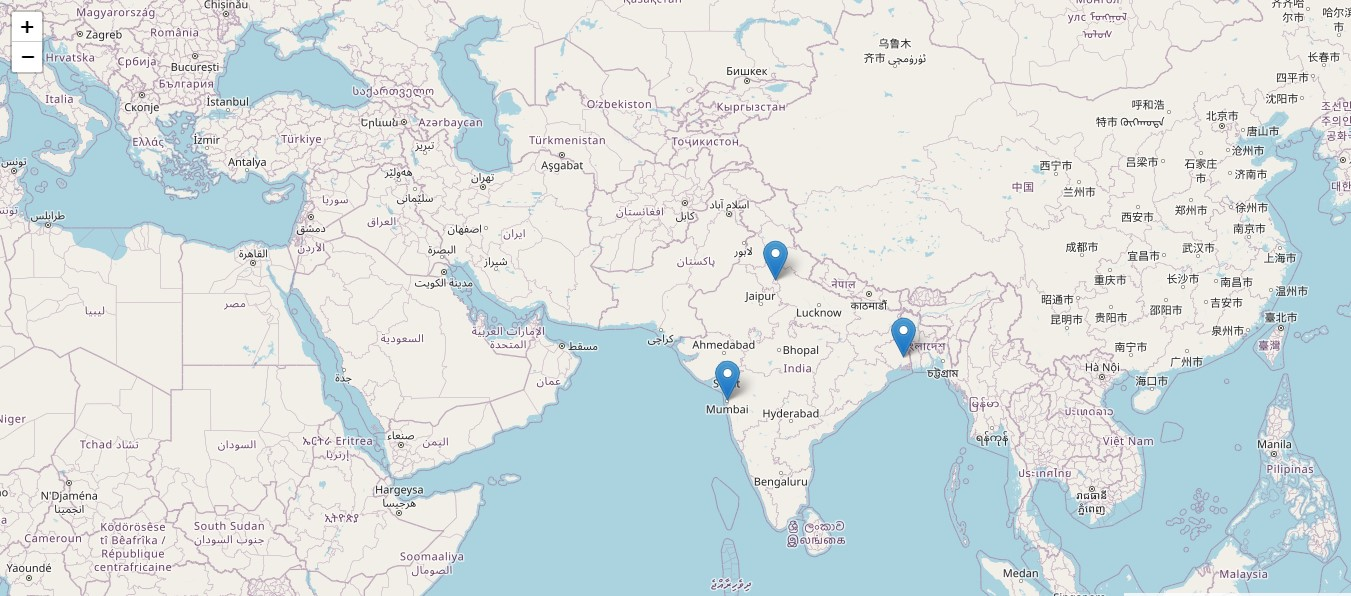

